
In this project , we predict number of footfalls in retail store.
We have generetaed dataset using chatGPT by using below query

please generate dataset in csv format containing 3650 rows. This dataset is about number of customer visited store for last 3650 days.
 It will contain below columns

date : date of record
no of customer : no of customer who visited store for particular day
temperature : outside temperature for particular day. temperature value can between 10 degree to 42 degree.
Rain : value can be 0 if it is not raining and 1 if it is raining.

there are some conditions that need to be followed
If temperature is higher , less people visit the store.
if it is raining less people should visit the store.
It can not happen that temperature is above 37 degree and it is raining.

while generating data , please take summer , rainy and winter season.

In summer season which last from march to June, temperature is above 35 degree, there would be no rain and less customer would visit the shop
 due to higher temperature
 In rainy season which last from July to October, temperature is between 20 degree to 35 degree, there would be  rain on daily basis and less customer would visit the shop
 due to rain
 In winter season which last from November to February , temperature is below 20 degree , there would be no rain , and more customer would visit the shop


In [235]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [236]:
data_path = 'customer_visits.csv'
df = pd.read_csv(data_path)

# print out sample dataset
print(len(df))
df.head()

3650


,date,no_of_customers,temperature,rain
0,2014-05-27,101,42,0
1,2014-05-28,64,40,0
2,2014-05-29,121,38,0
3,2014-05-30,70,40,0
4,2014-05-31,132,42,0


In [237]:
df.describe()

,no_of_customers,temperature,rain
count,3650.000000,3650.000000,3650.000000
mean,116.050959,27.029863,0.336986
std,54.614332,10.601656,0.472745
min,30.000000,10.000000,0.000000
25%,73.000000,17.000000,0.000000
50%,107.000000,28.000000,0.000000
75%,146.000000,37.000000,1.000000
max,250.000000,42.000000,1.000000


In [238]:
# set data index as date column
df.index = pd.to_datetime(df.date)
df_requried_columns = df.drop('date', axis=1)
df_requried_columns.head()

,no_of_customers,temperature,rain
date,,,
2014-05-27,101,42,0
2014-05-28,64,40,0
2014-05-29,121,38,0
2014-05-30,70,40,0
2014-05-31,132,42,0


In [239]:
# check number of nan values in dataframe, there wont be any NA as it is GPT generated data
df_requried_columns.isna().sum()

no_of_customers    0
temperature        0
rain               0
dtype: int64

In [240]:
df_final = df_requried_columns.resample('D').mean()
df_final.head()

,no_of_customers,temperature,rain
date,,,
2014-05-27,101.0,42.0,0.0
2014-05-28,64.0,40.0,0.0
2014-05-29,121.0,38.0,0.0
2014-05-30,70.0,40.0,0.0
2014-05-31,132.0,42.0,0.0


In [241]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_final)

# Define sequence length and features
sequence_length = 10  # Number of time steps in each sequence
num_features = len(df_final.columns)

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_data) - sequence_length):
    seq = scaled_data[i:i+sequence_length] ## create sequence using no_of_customers	temperature	rain
    label = scaled_data[i+sequence_length][0] ## create sequence using no_of_customers
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]

print("Train X shape:", train_x.shape)
print("Train Y shape:", train_y.shape)
print("Test X shape:", test_x.shape)
print("Test Y shape:", test_y.shape)


Train X shape: (2912, 10, 3)
Train Y shape: (2912,)
Test X shape: (728, 10, 3)
Test Y shape: (728,)


In [242]:
train_x

array([[[0.32272727, 1.        , 0.        ],
        [0.15454545, 0.9375    , 0.        ],
        [0.41363636, 0.875     , 0.        ],
        ...,
        [0.54090909, 0.9375    , 0.        ],
        [0.18636364, 0.875     , 0.        ],
        [0.09545455, 0.9375    , 0.        ]],

       [[0.15454545, 0.9375    , 0.        ],
        [0.41363636, 0.875     , 0.        ],
        [0.18181818, 0.9375    , 0.        ],
        ...,
        [0.18636364, 0.875     , 0.        ],
        [0.09545455, 0.9375    , 0.        ],
        [0.22272727, 0.90625   , 0.        ]],

       [[0.41363636, 0.875     , 0.        ],
        [0.18181818, 0.9375    , 0.        ],
        [0.46363636, 1.        , 0.        ],
        ...,
        [0.09545455, 0.9375    , 0.        ],
        [0.22272727, 0.90625   , 0.        ],
        [0.09545455, 0.96875   , 0.        ]],

       ...,

       [[0.42727273, 0.875     , 0.        ],
        [0.47272727, 0.875     , 0.        ],
        [0.47727273, 0

In [243]:
train_y

array([0.22272727, 0.09545455, 0.18181818, ..., 0.16818182, 0.35454545,
       0.15909091])

In [244]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [245]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10, 128)           67584     
                                                                 
 dropout_24 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_25 (LSTM)              (None, 10, 64)            49408     
                                                                 
 dropout_25 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_26 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [246]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_weights.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,  # Use part of the training data as validation
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
37/37 [==============================] - 10s 82ms/step - loss: 0.0525 - val_loss: 0.0319
Epoch 2/100
 2/37 [>.............................] - ETA: 1s - loss: 0.0281

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 2s 45ms/step - loss: 0.0320 - val_loss: 0.0305
Epoch 3/100
37/37 [==============================] - 2s 45ms/step - loss: 0.0310 - val_loss: 0.0300
Epoch 4/100
37/37 [==============================] - 2s 45ms/step - loss: 0.0310 - val_loss: 0.0299
Epoch 5/100
37/37 [==============================] - 2s 47ms/step - loss: 0.0302 - val_loss: 0.0290
Epoch 6/100
37/37 [==============================] - 3s 85ms/step - loss: 0.0304 - val_loss: 0.0295
Epoch 7/100
37/37 [==============================] - 2s 54ms/step - loss: 0.0290 - val_loss: 0.0303
Epoch 8/100
37/37 [==============================] - 2s 45ms/step - loss: 0.0302 - val_loss: 0.0288
Epoch 9/100
37/37 [==============================] - 2s 44ms/step - loss: 0.0298 - val_loss: 0.0280
Epoch 10/100
37/37 [==============================] - 2s 45ms/step - loss: 0.0302 - val_loss: 0.0277
Epoch 11/100
37/37 [==============================] - 2s 45ms/step - loss: 0.0285 - val_loss: 0.0284
Epoch 12/1

In [247]:
# Evaluate the best model on the test set
best_model = tf.keras.models.load_model('best_model_weights.h5')
test_loss = best_model.evaluate(test_x, test_y)
print("Test Loss:", test_loss)

23/23 [==============================] - 4s 16ms/step - loss: 0.0263
Test Loss: 0.02634178102016449


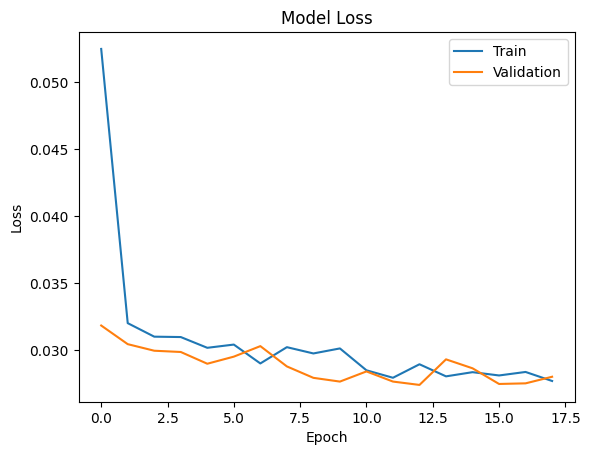

In [248]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [249]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have trained the model and have the 'best_model' object
# Also, 'test_x' and 'test_y' should be available

# Predict temperatures using the trained model
predictions = best_model.predict(test_x)

# Calculate evaluation metrics
mae = mean_absolute_error(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

23/23 [==============================] - 2s 11ms/step
Mean Absolute Error (MAE): 0.13394532934069395
Mean Squared Error (MSE): 0.026341782957672245
Root Mean Squared Error (RMSE): 0.162301518654855


In [250]:
# y_true values
test_y_copies = np.repeat(test_y.reshape(-1, 1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copies)[:,0]
true_temp.shape

(728,)

In [254]:
# predicted values
prediction = best_model.predict(test_x)
prediction_copies = np.repeat(prediction, 3, axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copies)[:,0]
#predicted_temp = scaler.inverse_transform(prediction_copies)
predicted_temp

23/23 [==============================] - 1s 19ms/step


array([ 97.332146,  96.75385 ,  95.6041  ,  94.43827 ,  94.235725,
        95.221924,  94.89342 ,  94.61589 ,  94.46972 ,  94.262474,
        94.44764 ,  93.885315,  92.27694 ,  90.76678 ,  90.3826  ,
        91.41735 ,  93.99805 ,  96.42764 ,  97.71086 ,  98.451225,
        98.82393 ,  98.11736 ,  96.22811 ,  94.599754,  93.245865,
        92.17341 ,  91.92998 ,  92.90775 ,  93.90027 ,  93.33237 ,
        92.09475 ,  90.89921 ,  89.65519 ,  88.196526,  87.96322 ,
        87.55582 ,  83.8422  ,  79.55749 ,  75.82677 ,  72.130554,
        69.539856,  67.99243 ,  66.77064 ,  67.326126,  67.84193 ,
        68.805756,  69.535645,  71.73933 ,  73.75759 ,  74.81846 ,
        75.702446,  76.07812 ,  77.91931 ,  79.156876,  79.655525,
        79.7866  ,  78.44088 ,  78.348694,  77.84703 ,  75.897446,
        73.87888 ,  72.607895,  70.447044,  70.1486  ,  70.08525 ,
        70.730576,  71.58114 ,  70.80685 ,  72.01089 ,  74.052895,
        75.79285 ,  76.184326,  75.82506 ,  75.574715,  75.949

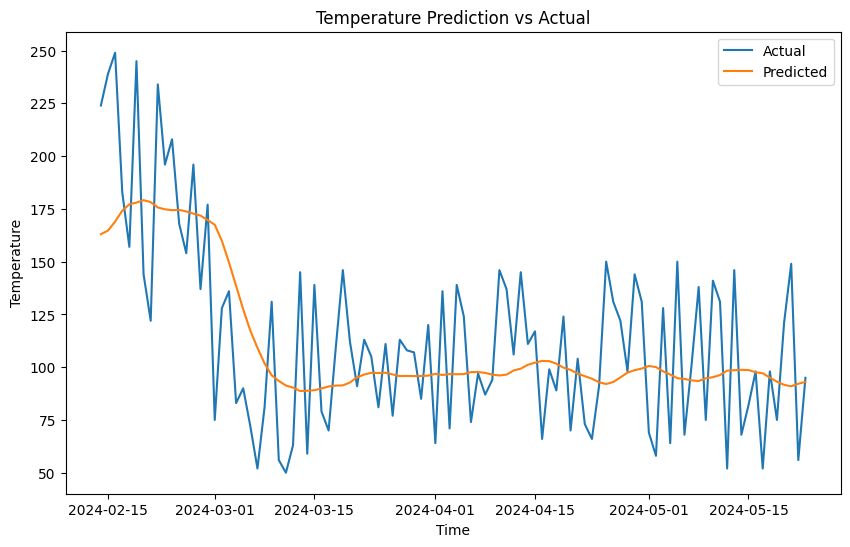

In [255]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(10, 6))
plt.plot(df_final.index[-100:], true_temp[-100:], label='Actual')
plt.plot(df_final.index[-100:], predicted_temp[-100:], label='Predicted')
plt.title('Temperature Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()